C:\Users\srupe\AppData\Local\Temp\ipykernel_20568\2857820209.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


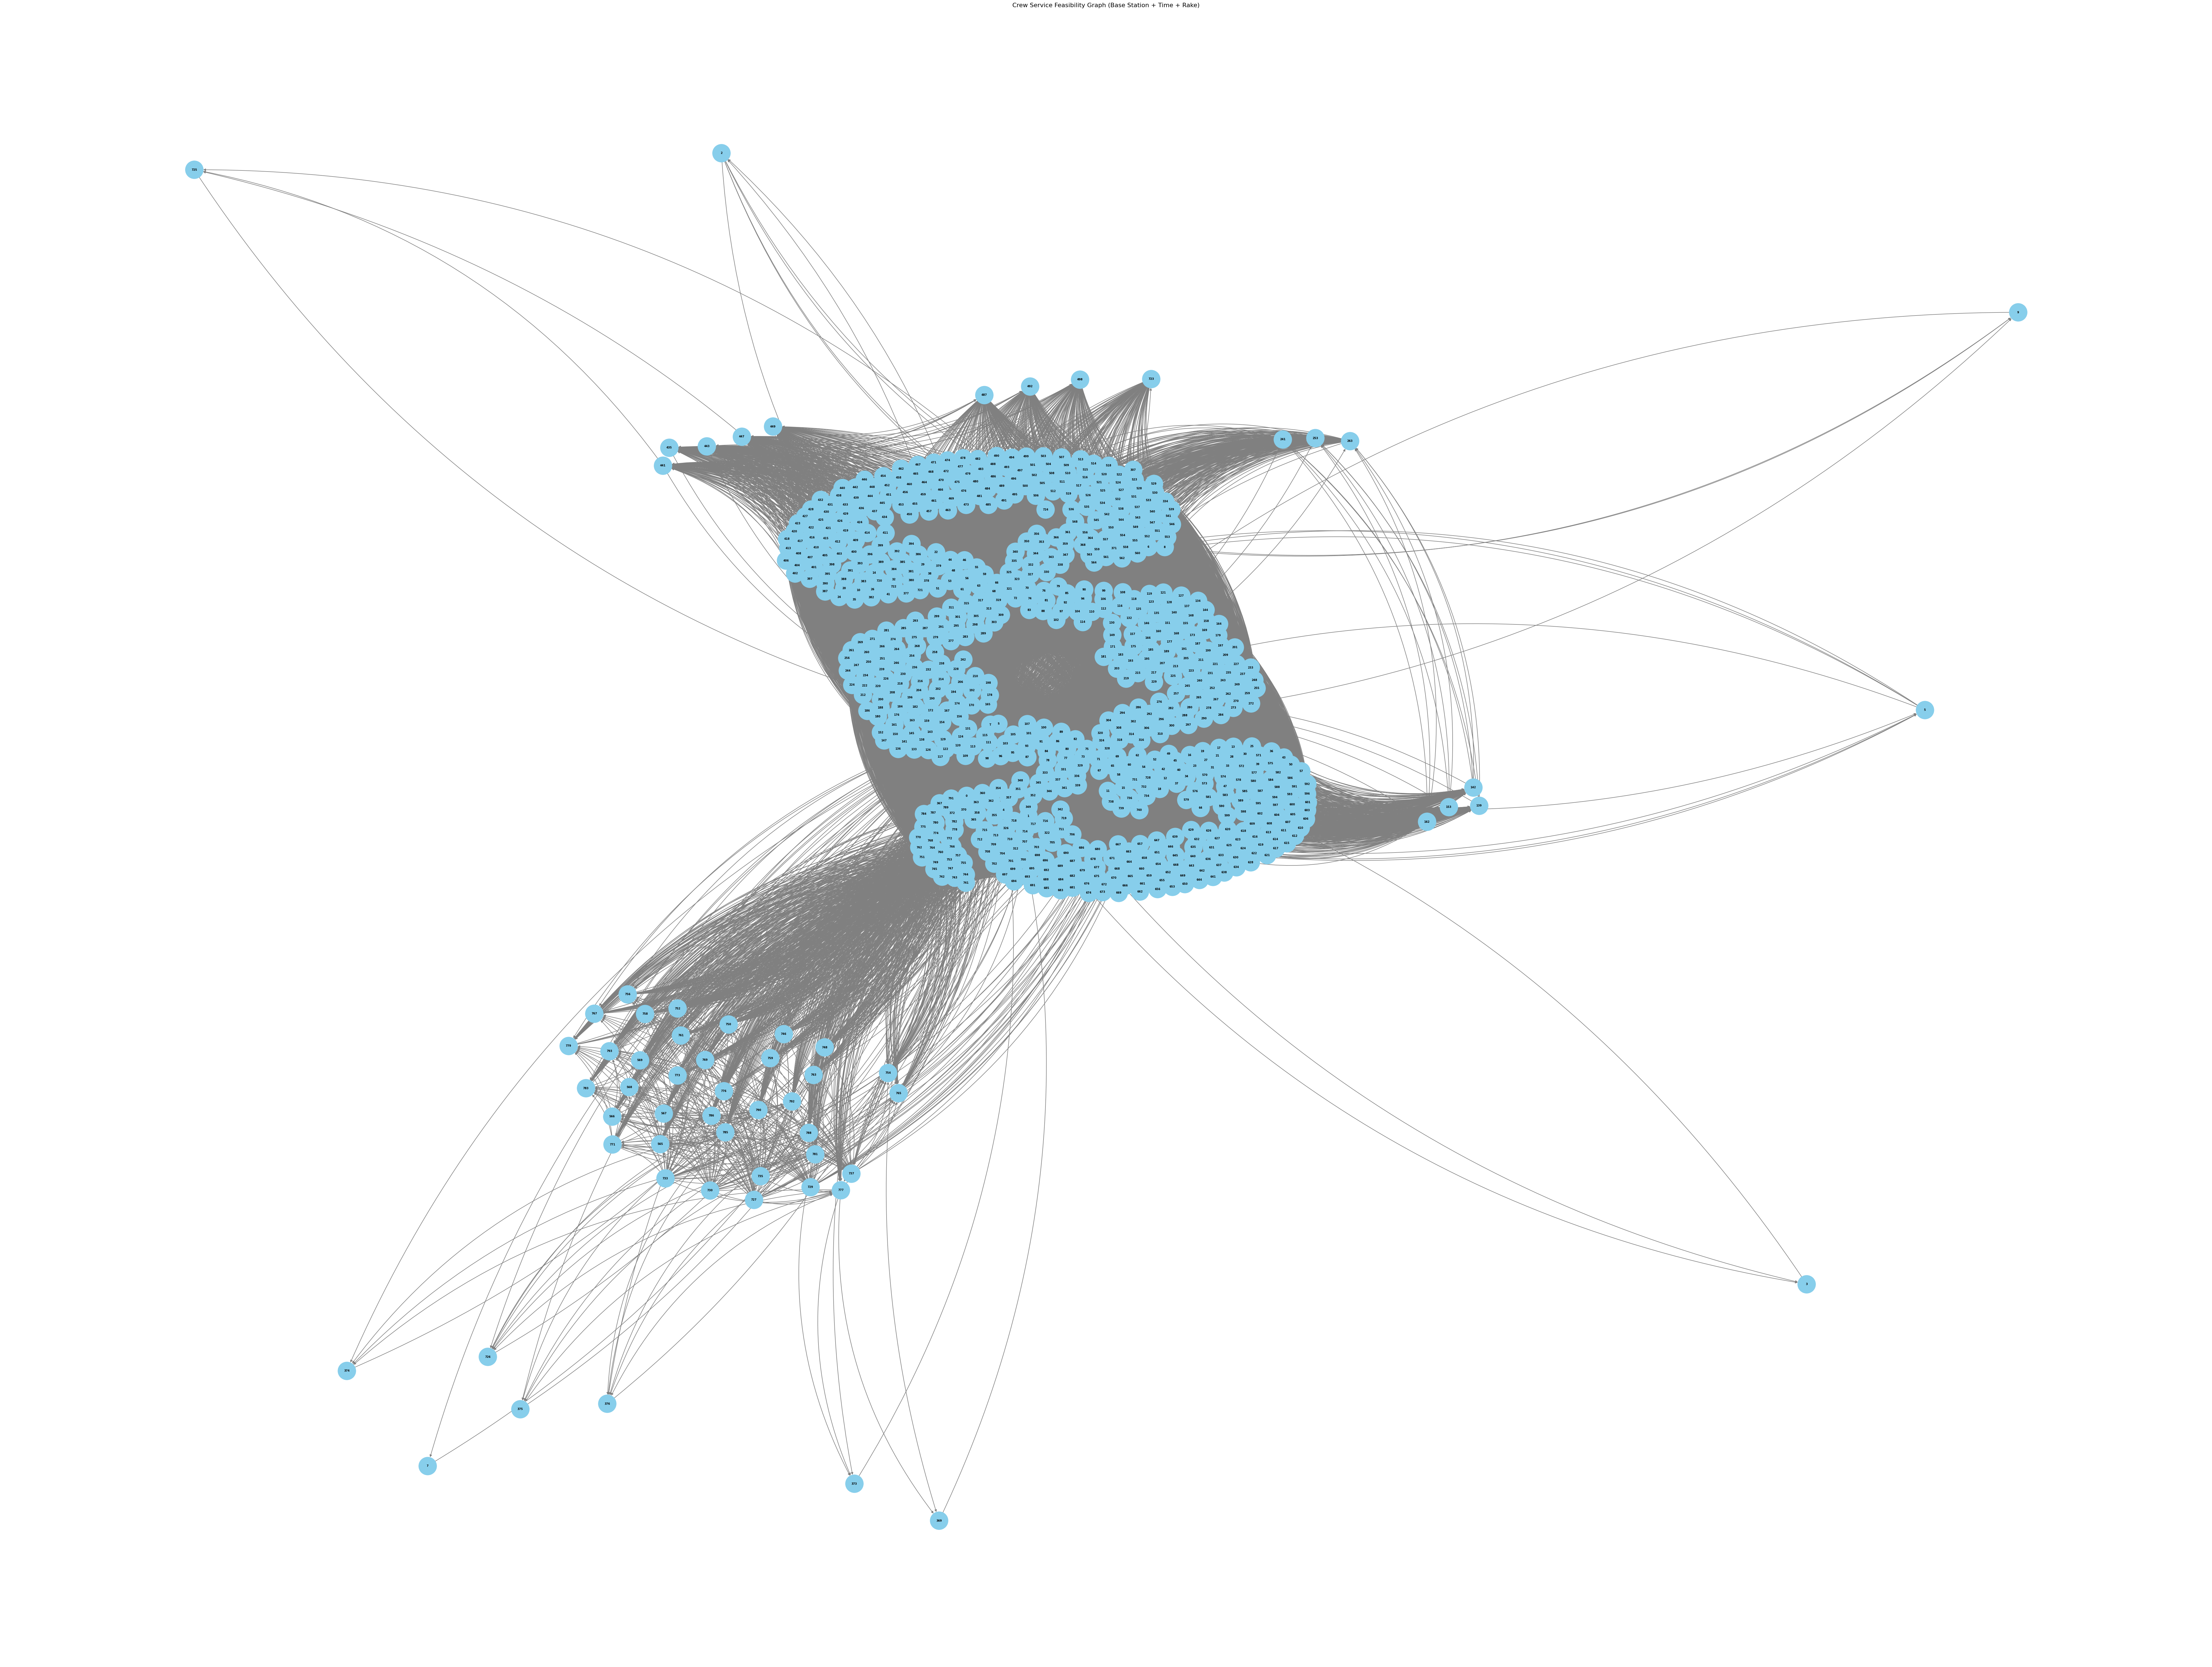

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# === Configuration ===
TIMETABLE_FILE = "C:/Users/srupe/Downloads/crew/mainLoop_rupesh.csv"
MIN_RAKE_GAP_MINUTES = 10  # Minimum required gap between different rakes


# === Utility Functions ===

def parse_time_to_minutes(t):
    """
    Converts a time string "HH:MM" into minutes since midnight.
    Handles times like "24:30" as 1470 minutes.
    """
    try:
        t = t.strip()
        hours, minutes = map(int, t.split(":"))
        return hours * 60 + minutes
    except:
        return None


def get_base_station_name(station):
    """
    Extracts the base station name (first word) in uppercase.
    """
    if pd.isna(station):
        return None
    return station.strip().split()[0].upper()


def is_feasible_connection(end_station, start_station, end_time, start_time, rake_a, rake_b):
    """
    Checks if a connection between two services is feasible.

    - Both services must be at the same base station.
    - If rake numbers are the same → allow if end_time <= start_time (even equal).
    - If rake numbers differ → require at least MIN_RAKE_GAP_MINUTES gap.
    """
    if end_station != start_station:
        return False

    if end_time is None or start_time is None:
        return False

    if rake_a == rake_b:
        return end_time <= start_time
    else:
        return (start_time - end_time) >= MIN_RAKE_GAP_MINUTES


# === Load and Process Data ===

df = pd.read_csv(TIMETABLE_FILE)
df.columns = df.columns.str.strip()
df['Service'] = df['Service'].astype(str)

# Convert start and end times to minutes
df['Start Minutes'] = df['Start Time'].apply(parse_time_to_minutes)
df['End Minutes'] = df['End Time'].apply(parse_time_to_minutes)

# Extract base station names
df['Base Start Station'] = df['Start Station'].apply(get_base_station_name)
df['Base End Station'] = df['End Station'].apply(get_base_station_name)


# === Build Graph ===

G = nx.DiGraph()
services = df['Service'].tolist()

# Add service nodes plus source and sink
G.add_nodes_from(services + ["S", "T"])

# Add edges from source to each service
for service in services:
    G.add_edge("S", service)

# Add feasible service-to-service connections
for i, row_a in df.iterrows():
    service_a = row_a['Service']
    end_station = row_a['Base End Station']
    end_time = row_a['End Minutes']
    rake_a = row_a.get('Rake Num', None)

    for j, row_b in df.iterrows():
        service_b = row_b['Service']
        if service_a == service_b:
            continue

        start_station = row_b['Base Start Station']
        start_time = row_b['Start Minutes']
        rake_b = row_b.get('Rake Num', None)

        if is_feasible_connection(end_station, start_station, end_time, start_time, rake_a, rake_b):
            G.add_edge(service_a, service_b)

# Add edges from each service to sink
for service in services:
    G.add_edge(service, "T")


# === Visualize the Graph ===

plt.figure(figsize=(80, 60))
pos = nx.spring_layout(G, seed=42, k=0.3, iterations=100)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    node_size=2200,
    font_size=7,
    font_weight='bold',
    edge_color='gray',
    width=1.4,
    arrows=True,
    arrowsize=12,
    connectionstyle="arc3,rad=0.2"
)

plt.title("Crew Service Feasibility Graph (Base Station + Time + Rake)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
print("Number of vertices:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of vertices: 796
Number of edges: 121932


In [ ]:
print(f"Nodes directly connected from 'S' ({len(list(G.successors('S')))}): {list(G.successors('S'))}")
print(f"Nodes directly connected to 'T' ({len(list(G.predecessors('T')))}): {list(G.predecessors('T'))}")

In [5]:
print(f"Nodes directly connected from '120' ({len(list(G.successors('120')))}): {list(G.successors('120'))}")
print(f"Nodes directly connected to '120' ({len(list(G.predecessors('120')))}): {list(G.predecessors('120'))}")

Nodes directly connected from '120' (233): ['629', '631', '151', '632', '153', '633', '155', '634', '157', '635', '158', '636', '160', '637', '162', '638', '164', '166', '639', '168', '640', '169', '641', '171', '642', '173', '643', '175', '644', '177', '645', '179', '646', '181', '647', '183', '648', '185', '649', '187', '650', '189', '651', '191', '652', '193', '653', '195', '654', '197', '655', '199', '656', '201', '657', '203', '658', '205', '659', '207', '660', '209', '661', '211', '662', '213', '663', '215', '664', '217', '665', '219', '666', '221', '667', '223', '668', '225', '669', '227', '670', '229', '671', '231', '672', '233', '673', '235', '674', '237', '675', '240', '676', '243', '677', '245', '678', '248', '679', '249', '680', '252', '681', '255', '257', '682', '683', '259', '684', '262', '685', '265', '686', '267', '687', '688', '270', '689', '272', '690', '273', '691', '276', '692', '278', '693', '280', '694', '282', '695', '284', '696', '286', '697', '288', '698', '290